<a href="https://colab.research.google.com/github/jplavorr/Data-Science/blob/main/Avalia%C3%A7%C3%A3o_de_Risco_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação de Risco de Crédito


<p align=center>
  <img src="https://www.helcim.com/images/an-overview-of-high-risk-credit-card-processing-154707404699-1536x864.jpg" height="500px">
</p>

##Entendendo Risco de Crédito

Quando instituições financeiras oferecem cartões de crédito ou outros tipos de empréstimos, existe o risco do cliente não pagar o empréstimo. Da mesma forma, se uma empresa oferece crédito a um cliente, existe o risco de o cliente não pagar suas faturas. 

Os riscos de crédito são calculados com base na capacidade geral do mutuário de pagar um empréstimo de acordo com seus termos originais. Para avaliar o risco de crédito em um empréstimo ao consumidor, os credores olham para os cinco Cs: histórico de crédito, capacidade de reembolso, capital, condições do empréstimo e garantia associada.


## Importar os Dados

Os dados que serão utilizados nesta análise estão disponíveis para download por meio [deste link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0). Consiste basicamente em um arquivo `csv` contendo 45.000 entradas e 43 colunas.

Este arquivo será importando para uma estrutura *DataFrame* utilizando a biblioteca `pandas` a fim de possibilitar sua manipulação e análise.

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [ ]:
#Importando Bibliotecas
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# random seed
np.random.seed(42)

# definir o estilo do seaborn para os plots
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importando os dados
df = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

In [ ]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

In [ ]:
#Formato do DataSet
print('Número de variáveis: {}'.format(df.shape[0]))
print('Número decolunas: {}'.format(df.shape[1]))

Número de variáveis: 45000
Número decolunas: 43


In [ ]:
#Cinco primeiras colunas
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


Aqui vemos as seguintes informações:

* O dataset possuí uma coluna com o ID do cliente. Essa variável não agrega para o modelo de machine learning, portanto, será retirada.

* A variável alvo se encontra na coluna `target_default	`.

* Informações importantes se encontram na coluna `score`, onde os `score_1` e `score_2` se encontram sob alguma codificação e os demais scores estão em valores numéricos.

* As colunas `reason`, `state`, `zip`, `channel`, `job_name`, `real_state` também se encontram sob alguma codificação. 

* A coluna `target_fraud` seria uma coluna alvo para algum modelo para classificar fraude. Portanto, iremos retirar essa coluna para nosso modelo de avaliação de risco de crédito.

* A coluna `lat_lon` está em formato *string* contendo uma tupla com as coordenadas.



As colunas que se encontram codificadas serão analisadas posteriormente para verificar se existe uma quantidade de classes que possa ser convertida em informação útil. As demais colunas serão análisadas individualmente para saber como agregam informação para nosso modelo.


In [ ]:
#Tipos das variáveis
df.dtypes

ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                                     

In [ ]:
#Informações Estatísticas
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


Com esses dados estatísticos podemos concluír:

* A coluna `external_data_provider_credit_checks_last_2_year` não agrega informação numérica.

* A coluna `external_data_provider_email_seen_before` informa -999 como valor minímo, isso dever ter sido posto para substituir valores ausentes. Portanto, iremos substituir esse valor por `NaN`.

* A coluna `reported_income` apresenta valores `inf`, iremos alterar eles para `NaN`.

Agora vamos ver quantos valores nulos estão presentes em cada coluna.

In [ ]:
#Porcentagem de valores nulos por coluna 
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

target_fraud                                        0.966178
last_amount_borrowed                                0.665689
last_borrowed_in_months                             0.665689
ok_since                                            0.589889
external_data_provider_credit_checks_last_2_year    0.502844
external_data_provider_credit_checks_last_year      0.336089
credit_limit                                        0.306667
n_issues                                            0.256533
facebook_profile                                    0.099067
marketing_channel                                   0.079511
job_name                                            0.074133
target_default                                      0.072422
external_data_provider_email_seen_before            0.049622
lat_lon                                             0.030289
user_agent                                          0.016044
n_bankruptcies                                      0.015489
n_defaulted_loans       

* A coluna `target_fraud` apresenta 96% de seus valores nulos, os valores ausentes possam ser dados pelos valores que não constam como fraude. Como ela será retirada para o treinamento do modelo, não é necessário se preocupar.

* A variável alvo `target_default` apresenta 7.2% de valores ausentes. Como são poucas, iremos retirar as informações ausentes do nosso modelo.

* Diversas variáveis como `['target_fraud', 'last_amount_borrowed', 'last_borrowed_in_months', 'ok_since', 'external_data_provider_credit_checks_last_2_year']` possuem mais da metade dos valores ausentes.

* As variáves `['external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues']` possuem entre 25-34% do seus valores ausentes.


Agora vamos observar os valores únicos por cada coluna.

In [ ]:
#Valores únicos
df.nunique().sort_values(ascending = False)

ids                                                 45000
profile_phone_number                                45000
score_6                                             45000
score_5                                             45000
score_4                                             45000
income                                              41211
reported_income                                     40025
application_time_applied                            35543
external_data_provider_first_name                   32886
job_name                                            32265
shipping_zip_code                                   28263
profile_tags                                        26131
lat_lon                                             22412
credit_limit                                        20928
reason                                              14874
last_amount_borrowed                                14325
external_data_provider_fraud_score                   1001
zip           

A contagem dos dados únicos mostram que as colunas `channel` e `external_data_provider_credit_checks_last_2_year` possuem apenas um valor.Como não ha maiores informações sobre cada feature iremos descartar as duas colunas para o modelo de Machine Learning.

Também se percebe que `profile_phone_number` possui 45 mil valores únicos, não trazendo provavelmente nenhuma informação que possa contribuir para a análise.

Também é importante saber que tipo de dataset estamos lidando.

Proporção entre Inadimplentes no Dataset:
False    0.779556
True     0.148022
Name: target_default, dtype: float64


[]

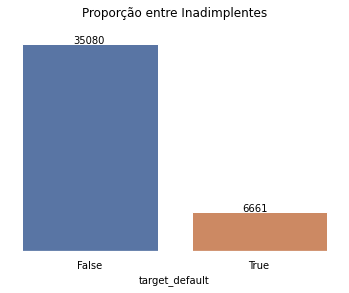

In [ ]:
#Proporção de Inadimplentes
print("Proporção entre Inadimplentes no Dataset:")
print(df['target_default'].value_counts() / df.shape[0])
x = ['No', 'Yes']
y = [df['target_default'].value_counts().values[0], df['target_default'].value_counts().values[1]]
fig, ax = plt.subplots()
#ax = plt.gca()
ax.set_xlabel('target_default')
#Deixar o eixo y invisivel 
ax.get_yaxis().set_visible(False)
ttl = ax.title
ttl.set_position([.5, 1.05])
#plt.draw()
sns.countplot(df['target_default'], ax=ax)
ax.set_title('Proporção entre Inadimplentes')
# This is the location for the annotated text
i = 1
j = 50
# Annotating the bar plot with the values (total death count)
for i in range(len(x)):
    plt.annotate(y[i], (-0.1 + i, y[i] + j))


plt.plot()

O dataset em questão é desbalanceado. Portanto, quando começarmos a treinar nosso modelo de machine learning teremos que aplicar alguma solução para nivelar essa desproporção para não gerar bias no modelo.

#Preparação dos Dados

Com as informações que obtivemos até agora, podemos começar a preparar nossos dados e fazer a limpeza. 

In [ ]:
#Criando cópia do dataset
df_clean = df.copy()

#Trocar os valores 'inf' por 'nan'
df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf, np.nan)

#Trocar valores -999 por 'nan'
df_clean.loc[df_clean['external_data_provider_email_seen_before'] == -999.0,'external_data_provider_email_seen_before'] = np.nan

#Descartando variáveis que não agregam
df_clean.drop(labels=['ids', 'target_fraud','external_data_provider_credit_checks_last_2_year',
                      'channel', 'profile_phone_number'], axis=1, inplace=True)

#Descartando variáveis que não apresentam informações pertinentes 
drop_var = ['reason', 'zip', 'job_name', 'external_data_provider_first_name',
            'shipping_zip_code', 'user_agent', 'profile_tags']
df_clean.drop(labels=drop_var, axis=1, inplace=True)

# elminar as entradas onde a variável alvo tem valor NaN
df_clean.dropna(subset=['target_default'], inplace=True)

Agora é preciso lidar com as colunas com uma quantidade razoável de valores `NaN`.

Apesar de não haver maiores informações sobre as *features*, podemos assumir como premissa que muitos valores são nulos devido a dois fatores:

1. Há alguns itens que não são obrigatórios durante a etapa de preenchimento dos formulários, como a informação sobre o perfil do cliente no Facebook; e
2. Não existe observação alguma referente à coluna, como é caso das colunas `['last_amount_borrowed', 'last_borrowed_in_months', 'n_issues']`.

As variáveos que se enquadram no segundo caso são informações relacionadas a emprestimos(`n_issues` está relacionadas ao número de problemas). Provávelmente o valor `NaN` seja colocado nos clientes que ainda não tenham tido nenhum problema ou feito algum pedido de emprestimo. Portanto, os valores `NaN` serão substituidos por zero.

Para as demais variáveis numéricas, será adotado o valor da mediana, e para as categóricas o valor mais frequente.

Para o preenchimento das colunas, irei usar a biblioteca [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#impute) do SKlearn.

In [ ]:
from sklearn.impute import SimpleImputer

#Seleciona as variáveis numéricas do dataset
num_df = df_clean.select_dtypes(exclude='object').columns
#Seleciona as variáveis categóricas do dataset
cat_df = df_clean.select_dtypes(include='object').columns

# substituição de valores ausentes
df_clean.last_amount_borrowed.fillna(value=0, inplace=True)
df_clean.last_borrowed_in_months.fillna(value=0, inplace=True)
df_clean.n_issues.fillna(value=0, inplace=True)

# variáveis numéricas
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_clean.loc[:,num_df])
df_clean.loc[:,num_df] = imputer.transform(df_clean.loc[:,num_df])

# variáveis categóricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_clean.loc[:,cat_df])
df_clean.loc[:,cat_df] = imputer.transform(df_clean.loc[:,cat_df])

Agora podemos verificar que as colunas não apresentam valores ausentes.

In [ ]:
#Porcentagem de valores nulos por coluna 
(df_clean.isnull().sum() / df_clean.shape[0]).sort_values(ascending=False)

shipping_state                                     0.0
real_state                                         0.0
score_1                                            0.0
score_2                                            0.0
score_3                                            0.0
score_4                                            0.0
score_5                                            0.0
score_6                                            0.0
risk_rate                                          0.0
last_amount_borrowed                               0.0
last_borrowed_in_months                            0.0
credit_limit                                       0.0
income                                             0.0
facebook_profile                                   0.0
state                                              0.0
ok_since                                           0.0
reported_income                                    0.0
n_bankruptcies                                     0.0
n_defaulte

#Análise Exploratória

Agora preciso tirar informações das colunas: `email`, `marketing_channel`, `facebook_profile`, `income`, `reported_income`, etc . Irei fazer uma análise em cima dessas colunas para ver se agregam informação ao modelo de machine learning.

In [ ]:
df_clean.loc[df_clean['email'] == 'gmaill.com','email'] = 'gmail.com'
df_clean.loc[df_clean['email'] == 'hotmaill.com','email'] = 'hotmail.com'

Text(0.5, 1.0, 'Leal')

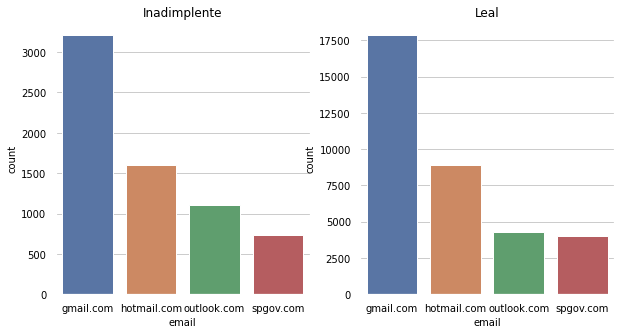

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

sns.countplot(df_clean[df_clean.target_default == True]['email'], ax=ax[0],order = df_clean[df_clean.target_default == True]['email'].value_counts().index).set_title('Inadimplente')
sns.countplot(df_clean[df_clean.target_default == False]['email'], ax=ax[1],order = df_clean[df_clean.target_default == False]['email'].value_counts().index).set_title('Leal')

Text(0.5, 1.0, 'Leal')

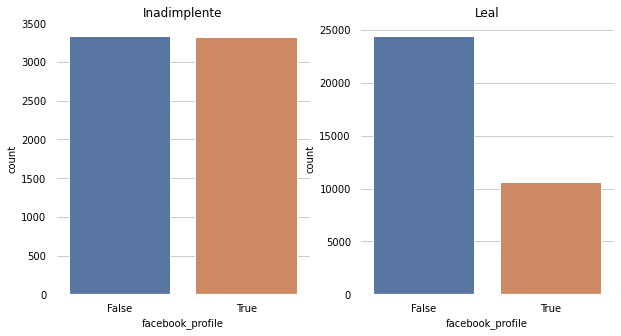

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

sns.countplot(df_clean[df_clean.target_default == True]['facebook_profile'], ax=ax[0],order = df_clean[df_clean.target_default == True]['facebook_profile'].value_counts().index).set_title('Inadimplente')
sns.countplot(df_clean[df_clean.target_default == False]['facebook_profile'], ax=ax[1],order = df_clean[df_clean.target_default == False]['facebook_profile'].value_counts().index).set_title('Leal')

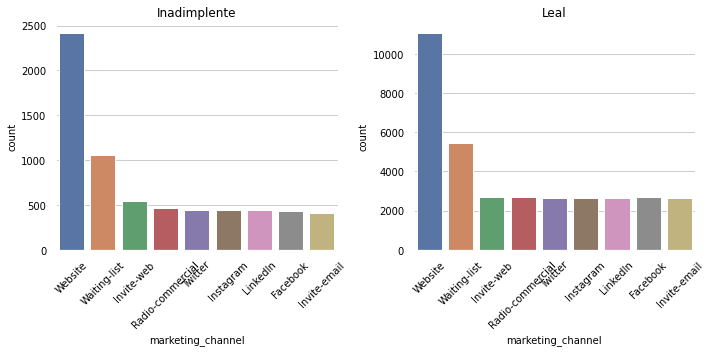

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

sns.countplot(df_clean[df_clean.target_default == True]['marketing_channel'], ax=ax[0],order = df_clean[df_clean.target_default == True]['marketing_channel'].value_counts().index).set_title('Inadimplente')
sns.countplot(df_clean[df_clean.target_default == False]['marketing_channel'], ax=ax[1],order = df_clean[df_clean.target_default == True]['marketing_channel'].value_counts().index).set_title('Leal') 
for ax in fig.axes:
    ax.tick_params('x', labelrotation=45 )
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Leal')

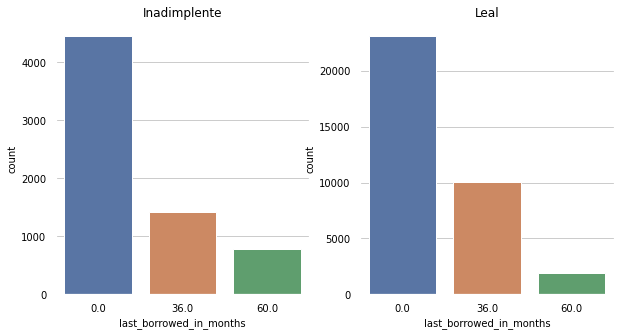

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

sns.countplot(df_clean[df_clean.target_default == True]['last_borrowed_in_months'], ax=ax[0],order = df_clean[df_clean.target_default == True]['last_borrowed_in_months'].value_counts().index).set_title('Inadimplente')
sns.countplot(df_clean[df_clean.target_default == False]['last_borrowed_in_months'], ax=ax[1],order = df_clean[df_clean.target_default == False]['last_borrowed_in_months'].value_counts().index).set_title('Leal')

Nessa análise relacionada as diferenças de características dos clientes inadimplentes e leais. Vemos que as variáveis `email` e `marketing_channel` são variáveis com muitas entradas e que não parecem agregar muita informação sobre os clientes, portanto, irei dropar elas do dataset. 

Já as demais variáveis, podemos ver as seguintes informações ressaltando:

* Que a grande maioria de clientes leais não possui a rede social facebook.
* Entre os clientes leias, a variável `last_borrowed_in_months` tem uma proporção muito pequena paro o valor 60.

Agora, vamos analisar a correlação entre as variáveis numéricas, para ter uma noção de como estão distribuídas.

In [ ]:
#Descartando variáveis que não agregam
df_clean.drop(labels=['marketing_channel','email'], axis=1, inplace=True)

In [ ]:
# criar uma matriz de correlação
corr = df_clean[['n_accounts', 'n_issues', 'income', 'reported_income',
    'n_bankruptcies', 'score_3', 'score_4', 'score_5', 'score_6','external_data_provider_fraud_score',
    'external_data_provider_email_seen_before', 'application_time_in_funnel',
    'external_data_provider_credit_checks_last_month',
    'external_data_provider_credit_checks_last_year','target_default']].corr()



# mostrar a matriz de correlação
display(corr)

,n_accounts,n_issues,income,reported_income,n_bankruptcies,score_3,score_4,score_5,score_6,external_data_provider_fraud_score,external_data_provider_email_seen_before,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,target_default
n_accounts,1.000000,0.660046,0.166803,0.000244,-0.032071,0.192905,-0.008531,0.006279,-0.005090,0.000789,-0.000475,0.003111,-0.001414,0.005243,0.015127
n_issues,0.660046,1.000000,0.106837,-0.007038,0.029681,0.193279,-0.007939,0.001478,-0.000792,0.000985,-0.003625,0.006692,0.000951,0.008333,0.022401
income,0.166803,0.106837,1.000000,0.003273,-0.042488,-0.109759,-0.002408,-0.003057,0.013329,0.001386,0.009511,-0.007000,-0.001833,0.000340,-0.043243
reported_income,0.000244,-0.007038,0.003273,1.000000,-0.002740,0.000559,0.009081,-0.004170,0.003624,-0.001620,-0.000965,-0.002227,0.003280,-0.006626,-0.001628
n_bankruptcies,-0.032071,0.029681,-0.042488,-0.002740,1.000000,-0.025203,-0.007264,0.004647,0.006616,0.011629,0.004167,0.007313,0.005287,-0.000614,0.014014
score_3,0.192905,0.193279,-0.109759,0.000559,-0.025203,1.000000,-0.001179,0.001647,-0.002400,0.001861,-0.010214,0.003227,0.000731,0.010049,0.047100
score_4,-0.008531,-0.007939,-0.002408,0.009081,-0.007264,-0.001179,1.000000,0.008684,0.004547,-0.003493,-0.003918,0.002639,0.003987,0.006770,0.002115
score_5,0.006279,0.001478,-0.003057,-0.004170,0.004647,0.001647,0.008684,1.000000,0.003413,-0.002761,0.003032,0.006210,0.001366,-0.002198,-0.004584
score_6,-0.005090,-0.000792,0.013329,0.003624,0.006616,-0.002400,0.004547,0.003413,1.000000,0.001096,-0.001466,0.000829,0.005298,-0.002225,-0.001750
external_data_provider_fraud_score,0.000789,0.000985,0.001386,-0.001620,0.011629,0.001861,-0.003493,-0.002761,0.001096,1.000000,0.004703,0.007939,0.001823,-0.010869,0.000248


Vemos que essas variáveis não estão correlacionadas. Só as variáveis `n_accounts` e `n_issue` apresentam uma correlação considerável. Mas ainda sim, irei manter elas presentes no modelo.

#Feature Engineering
O dataset possuí valores de certa forma "complicados" (como a coluna de `application_time_applied`, `state` e `lat_lon`). Será feita uma modificação nessas colunas com o propósito de deixar elas aptas para extrair informações para o modelo.

###Variável Codificada
A variável codificada `state` apresenta 50 valores únicos, por se tratar de uma variável codificada, deve ser uma informação importante para a empresa. Quando formos aplicar o método `get_dummies` nessa variável, ela irá gerar 50 novas colunas e isso pode aumentar a complexidade do nosso modelo. Portanto, irei agrupar seus valores em bins para ajudar o modelo a reconhecer aonde estão mais presentes os clientes inadimplentes e para diminuir a complexidade.

In [ ]:
#Fazendo uma copia do dataset para análise a parte
for new_idx, idx in enumerate(df_clean.state.unique()):
     df_clean.loc[df_clean['state'] == idx, ['state']] = new_idx

In [ ]:
df_clean['category_state'] = pd.cut(df_clean['state'],
                                   bins = list(range(5,55, 5)),
                                   labels = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9'])

In [ ]:
def to_category_state(state):
    if state >= 0 and state < 5: 
        return 'bin1'
    if state >= 5 and state < 10:      
        return 'bin2'
    if state >= 10 and state < 15: 
        return 'bin3'
    if state >= 15 and state < 20: 
        return 'bin4'
    if state >= 20 and state < 25: 
        return 'bin5'
    if state >= 25 and state < 30: 
        return 'bin6'
    if state >= 30 and state < 35: 
        return 'bin7'
    if state >= 35 and state < 40: 
        return 'bin8' 
    if state >= 40 and state < 45: 
        return 'bin9'
    if state >= 45 and state < 50: 
        return 'bin10'

# transform application_time_applied into Application_daytime_applied'
df_clean['category_state'] = df_clean['state'].apply(to_category_state)

# drop the application_time_applied column
df_clean.drop(columns=['state'],
                    inplace=True)

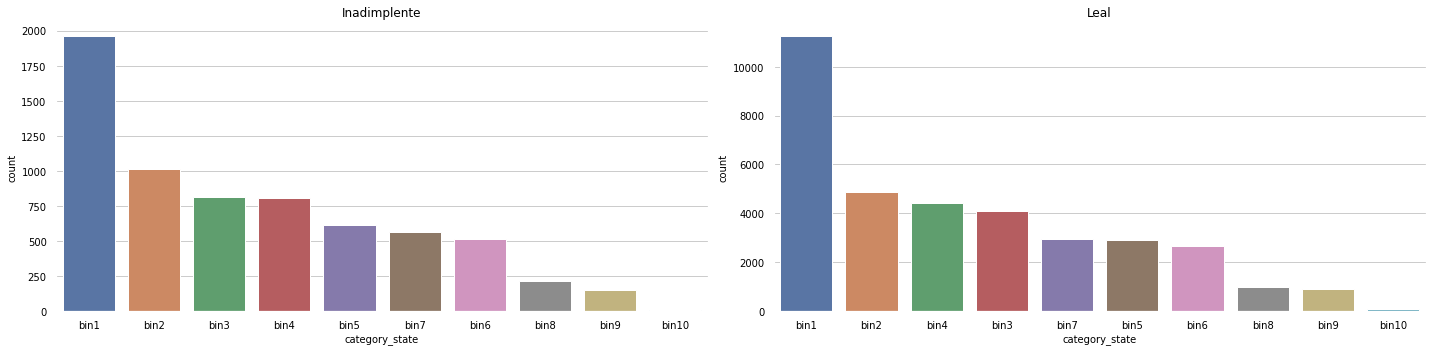

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,5))

sns.countplot(df_clean[df_clean.target_default == True]['category_state'], ax=ax[0], order = df_clean[df_clean.target_default == True]['category_state'].value_counts().index).set_title('Inadimplente')
sns.countplot(df_clean[df_clean.target_default == False]['category_state'], ax=ax[1],order = df_clean[df_clean.target_default == False]['category_state'].value_counts().index).set_title('Leal') 
plt.tight_layout()
plt.show()

###Latitude & Longitude
A variável latitude e longitude se encontra numa única coluna na forma de pares ordenados. Iremos separar essas tuplas em duas colunas `Latitude` e `Longitude`. 

In [ ]:
df_clean.lat_lon.head()

0      (-29.151545708122246, -51.1386461804385)
1     (-19.687710705798963, -47.94151536525154)
2    (-28.748023890412284, -51.867279334353995)
3     (-17.520650158450454, -39.75801139933186)
4     (-16.574259446978008, -39.90990074785962)
Name: lat_lon, dtype: object

In [ ]:
# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in df_clean['lat_lon']:
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[0])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[1])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
df_clean['Latitude'] = lat
df_clean['Longitude'] = lon
df_clean["Latitude"] = df_clean["Latitude"].str.replace("(", "")
df_clean["Longitude"] = df_clean["Longitude"].str.replace(")", "")
df_clean.drop('lat_lon', axis=1, inplace=True)
df_clean["Latitude"] = pd.to_numeric(df_clean['Latitude'])
df_clean["Longitude"] = pd.to_numeric(df_clean['Longitude'])

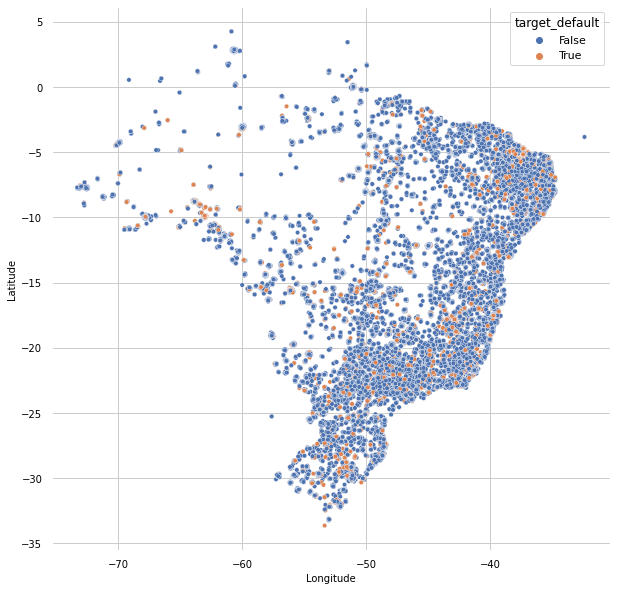

In [ ]:
#Gráfico de Dispersão da localização de cada cliente.
#Laranja = Inadimplente
#Azul = Leal
plt.figure(figsize=(10,10))
sns.scatterplot(x='Longitude', y='Latitude', hue='target_default',s=20, data=df_clean);

O dataset apresenta a coluna `shipping_state` com o estado de cada cliente. Ao invés de trabalhar com essa coluna, irei clusterizar as variáveis latitude e longitude usando a bilioteca `KMeans` criando uma nova coluna com os clusters.

In [ ]:
from sklearn.cluster import KMeans 
# creates 10 clusters using k-means clustering algorithm.
kmeans = KMeans(10)
clusters = kmeans.fit_predict(df_clean[['Latitude','Longitude']])
df_clean['pickup_cluster'] = kmeans.predict(df_clean[['Latitude','Longitude']])

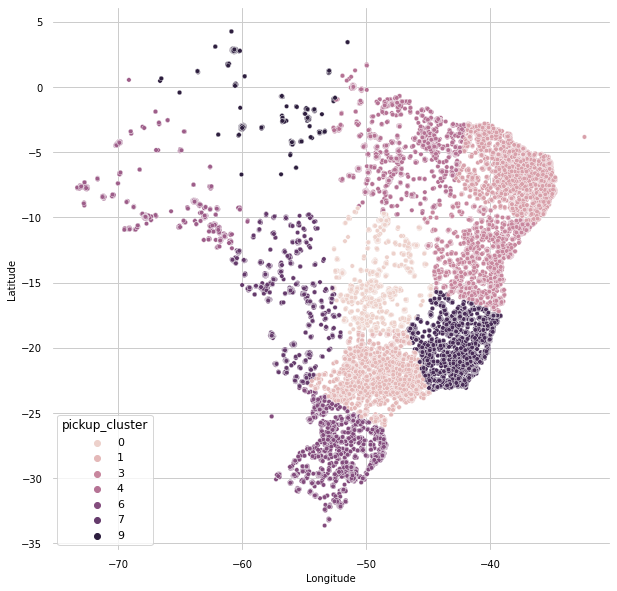

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Longitude', y='Latitude', hue='pickup_cluster',s=20, data=df_clean);

In [ ]:
#Mudar o valor da coluna para string
df_clean['pickup_cluster'] = df_clean['pickup_cluster'].astype(str)

## Horário da Aplicação

Da mesma forma que fizemos acima com a geolocalização, queremos clusterizar os horários em que cada pessoa solicitou o emprestimo (Manhã, tarde, noite, etc), para sabermos se o horário é um fator essencial para nosso modelo.

Antes de usar a função `to_datetime`, é preciso que seja feita uma limpeza na coluna, pois ela apresenta muitos valores de forma errada para biblioteca. 
Por exemplo, possuí colunas com valores: 24:60:60. Para isso, deixar todos esses valores em seus formatos corretos.



1.  Valores na forma: xx:xx:60 - iremos transformar os segundos em zero e adicionar 1 na coluna dos minutos
2. Valores na forma: 24:xx:xx serão passados para 00:xx:xx
3. Valores na forma: xx:60:xx - iremos transformar os minutos em zero e adicionar 1 na coluna das horas
* Iremos também colcoar uma condição caso `new_value == 24` sejá passado para 00h
* Os elementos da forma 59:60 quando passados pelo processo 1 irão ser corrigidos no processo 3.






In [ ]:
#Ajeitando os valores com 60 na ultima casa
list_second = []
for seconds in df_clean[df_clean.application_time_applied.str.endswith('60', na=False)]['application_time_applied'].values:
    new_int = int(seconds[3:5]) + 1
    if new_int < 10:
      new = seconds.replace(seconds[3:5], '0' + str(new_int))
      new_second = new.replace(new[6:], '00')
      list_second.append(new_second)
    else:
      new = seconds.replace(seconds[3:5], str(new_int))
      new_second = new.replace(new[6:], '00')
      list_second.append(new_second)

#Substituindo os valores no dataframe
j = 0
for i in df_clean[df_clean.application_time_applied.str.endswith('60', na=False)]['application_time_applied'].index:
  df_clean.loc[i, 'application_time_applied'] = list_second[j]
  j = j+1

In [ ]:
#Ajeitando os valores com 24h na primeira casa
list_night = []
for night in df_clean[df_clean.application_time_applied.str.startswith('24', na=False)]['application_time_applied'].values:
      new = night.replace(night[0:2], '00')
      list_night.append(new)

#Substituindo os valores no dataframe
j = 0
for i in df_clean[df_clean.application_time_applied.str.startswith('24', na=False)]['application_time_applied'].index:
  df_clean.loc[i, 'application_time_applied'] = list_night[j]
  j = j+1

In [ ]:
#Ajeitando os valores com 60 na segunda casa
list_hour = []
for hour in df_clean[df_clean['application_time_applied'].str.contains(':60:', regex=True, na=True)]['application_time_applied'].values:
    new_int = int(hour[0:2]) + 1
    if new_int < 10:
      new = hour.replace(hour[0:2], '0' + str(new_int))
      new_hour = new.replace(new[3:5], '00')
      list_hour.append(new_hour)
    elif new_int == 24:
      new = hour.replace(hour[0:2], '00')
      new_hour = new.replace(new[3:5], '00')
      list_hour.append(new_hour)
    else:
      new = hour.replace(hour[0:2], str(new_int))
      new_hour = new.replace(new[3:5], '00')
      list_hour.append(new_hour)

#Substituindo os valores no dataframe
j = 0
for i in df_clean[df_clean['application_time_applied'].str.contains(':60:', regex=True, na=True)]['application_time_applied'].index:
  df_clean.loc[i, 'application_time_applied'] = list_hour[j]
  j = j+1

In [ ]:
#Passando a coluna para o formato datetime
df_clean['application_time_applied'] = pd.to_datetime(df_clean['application_time_applied'])

Agora a coluna `application_time_applied` está no formato DateTime. Dessa forma, iremos clusterizar por períodos do dia:

* Madrugada, Manhã, Tarde e Noite.

In [ ]:
def to_daytime(application_time_applied):
    if application_time_applied.hour >= 0 and application_time_applied.hour < 6: 
        return 'Madrugada'
    if application_time_applied.hour >= 6 and application_time_applied.hour < 12:      
        return 'Manha'
    if application_time_applied.hour >= 6 and application_time_applied.hour < 18: 
        return 'Tarde'
    if application_time_applied.hour >= 18 and application_time_applied.hour <= 23: 
        return 'Noite'

# transform application_time_applied into Application_daytime_applied'
df_clean['Application_daytime_applied'] = df_clean['application_time_applied'].apply(to_daytime)

# drop the application_time_applied column
df_clean.drop(columns=['application_time_applied'],
                    inplace=True)

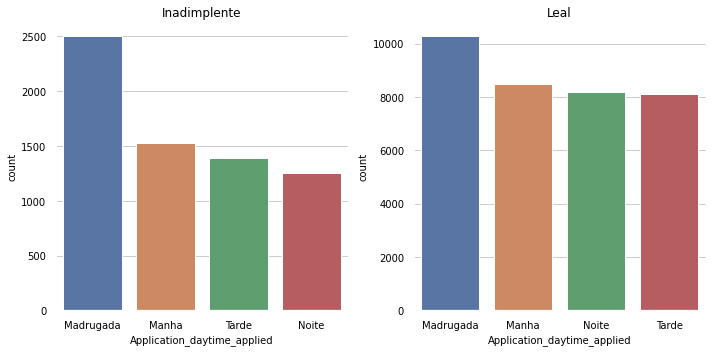

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

sns.countplot(df_clean[df_clean.target_default == True]['Application_daytime_applied'], ax=ax[0], order = df_clean[df_clean.target_default == True]['Application_daytime_applied'].value_counts().index).set_title('Inadimplente')
sns.countplot(df_clean[df_clean.target_default == False]['Application_daytime_applied'], ax=ax[1], order = df_clean[df_clean.target_default == False]['Application_daytime_applied'].value_counts().index).set_title('Leal') 

plt.tight_layout()
plt.show()

In [ ]:
df_clean.drop(columns=['Latitude', 'Longitude', 'shipping_state'], axis=1, inplace = True)

# Preparando os Dados

Antes iniciar o modelo de machine learning que irá usar esses dados, precisamos realizar alguns pré-processamento. Considerando que muitas features são categoricas, temos que transfoma-lás em numpericas para ter melhor previsão do modelo, iremos pré-processar nossos dados usando `LabelEncoder` do Scikit Learn para as variáveis ​​binárias e `get_dummies` do pandas para as outras variáveis ​​categóricas.

In [ ]:
#Valores categoricos Unicos
binary_categorical_values = [] 
multiple_categorical_values =[]
for col in df_clean.select_dtypes(['object', 'bool']).columns:
    if df_clean[col].value_counts().shape[0] == 2:
        binary_categorical_values.append(col)
    else:
        multiple_categorical_values.append(col)

print("Variaveis categoricas com dois valores:", binary_categorical_values)
print("\nVariáveis Categóricas com Mais de dois Valores:", multiple_categorical_values)

Variaveis categoricas com dois valores: ['target_default', 'facebook_profile']

Variáveis Categóricas com Mais de dois Valores: ['score_1', 'score_2', 'real_state', 'category_state', 'pickup_cluster', 'Application_daytime_applied']


In [ ]:
#Import Library
from sklearn.preprocessing import LabelEncoder
#Creating a new Copy of the DataFrame
df_proc = df_clean.copy()
le = LabelEncoder()
#Label Enconding for Binary Variables
for i in binary_categorical_values:
  df_proc[i] = le.fit_transform(df_proc[i])


In [ ]:
# Encoding for categorical columns with multiple classes
df_proc = pd.get_dummies(df_proc, columns=multiple_categorical_values) 

In [ ]:
df_proc.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_1Rk8w4Ucd5yR3KcqZzLdow==,score_1_4DLlLW62jReXaqbPaHp1vQ==,score_1_8k8UDR4Yx0qasAjkGrUZLw==,score_1_DGCQep2AE5QRkNCshIAlFQ==,score_1_e4NYDor1NOw6XKGE60AWFw==,score_1_fyrlulOiZ+5hoFqLa6UbDQ==,score_1_smzX0nxh5QlePvtVf6EAeg==,score_2_+2hzpeP1RWr8PEvL1WTUdw==,score_2_+CxEO4w7jv3QPI/BQbyqAA==,score_2_/tdlnWjXoZ3OjdtBXzdOJQ==,score_2_5/uMrqKj3OL/Xk5OrGx9fg==,score_2_55UK234RR1d7HIWJjmq9tw==,score_2_6J1ZMTzN5GKHXnhM4J1JbA==,score_2_7h+tk4z7O9brtBSe1rNjxA==,score_2_7h8PTkrlTWUPP3yuyP4rUg==,score_2_A+QuW1n/ABeiVVe/9CRZ9Q==,score_2_Fv28Bz0YRTVAT5kl1bAV6g==,score_2_IOVu8au3ISbo6+zmfnYwMg==,...,score_2_ky19q4V1ZqgL3jnHX0wKDw==,score_2_mX2VRRG38RPiHX+MfjefRw==,score_2_osCzpM4hJrxugqWWuZmMWw==,score_2_pAzpxkhjPsjWldgSX21+zg==,score_2_rJZgTmANW3PjOCQLCcp4iQ==,score_2_tHpS8e9F8d9zg3iOQM9tsA==,score_2_tQUTfUyeuGkhRotd+6WjVg==,score_2_vJyc9xom9v7hwFMPTIpmKw==,score_2_w1miZqhB5+RSamEQJa0rqg==,score_2_wjdj2vxjWoDsEIk0l09ynw==,score_2_wkeCdGeu5sEv4/fjwR0aDg==,real_state_+qWF9pJpVGtTFn4vFjb/cg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==,category_state_bin1,category_state_bin10,category_state_bin2,category_state_bin3,category_state_bin4,category_state_bin5,category_state_bin6,category_state_bin7,category_state_bin8,category_state_bin9,pickup_cluster_0,pickup_cluster_1,pickup_cluster_2,pickup_cluster_3,pickup_cluster_4,pickup_cluster_5,pickup_cluster_6,pickup_cluster_7,pickup_cluster_8,pickup_cluster_9,Application_daytime_applied_Madrugada,Application_daytime_applied_Manha,Application_daytime_applied_Noite,Application_daytime_applied_Tarde
0,0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,1,32.0,0.0,0.0,18.0,18.0,444.0,2.0,0.0,51.0,645.0,57849.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,0,50.0,0.0,0.0,14.0,14.0,346.0,1.0,0.0,17.0,243.0,4902.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,1,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,0,32.0,0.0,0.0,10.0,0.0,6.0,2.0,1.0,9.0,65.0,163679.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,0,32.0,1.0,0.0,19.0,19.0,406.0,3.0,1.0,38.0,815.0,1086.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,1,32.0,0.0,0.0,11.0,0.0,240.0,2.0,1.0,46.0,320.0,198618.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


#Modelo de Machine Learning

Tendo visto o tipo de dados presentes nesse modelo, irei usar modelos baseados em **gradient boosting**, que é uma técnica para problemas de classificação, que produz um modelo de previsão na forma de um *ensemble*(Esemble acontece quando usa múltiplos modelos) de modelos de previsão, que são geralmente árvores de decisão. Ela constrói o modelo sequencialmente e cada um desses modelos subsequentes tenta reduzir o erro do modelo anterior.

Irei fazer um `gridsearch` com os seguintes algoritmos de gradient boosting para determinar qual produz melhores resultados:

* [XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
* [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


Antes de preparar os modelos, precisamos dividir os dados em conjuntos de treinamento e teste



In [ ]:
#Importando a biblioteca para efetuar o split do dataset
from sklearn.model_selection import train_test_split
#Split
X = df_proc.drop('target_default', axis = 1)
#Variável alvo
y = df_proc['target_default']

#Separar entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True )

Para avaliar o modelo, irei considerar as seguintes métricas:

* **Precision:** Quantifica o número de **previsões positivas** dentre todas as previsões marcadas como positiva.
$$ Precision = \dfrac{TP}{(TP + FP)} $$
* **Recall:** quantifica o número de previsões de classe positivas feitas de todos os exemplos positivos no conjunto de dados (Ele retorna a quantidade de previsões corretas)
$$ Recall = \dfrac{TP}{(TP + FN)} $$

* **F1 Score:** é uma métrica útil quando precisamos buscar um equilíbrio entre precisão e recall. 
$$ F1 Score = \dfrac{(2 \cdot Precision \cdot Recall)}{(Precision + Recall)} $$


Onde:
*  **TP - True Positive:** Foi classificada como positiva e realmente é
*  **FN - False Negative:** Foi classificada como negativa mas é positiva
*  **FP - False Positive:** Foi classificada como positiva e é negativa
*  **TN - True Negative:** Foi classificada como negativa e realmente é


Para essa etapa, iremos criar um projeto simples usando `Cross-validation`, aonde o foco é comparar o desempenho dos diferentes modelos de machine learning citados acima, após isso, iremos escolher o modelo que se saiu melhor e melhorar ele com o uso de hiperparámetros. 


###Balanceando os Dados
Quando estamos lidando com conjutos de dados desbalanceados, precisamos fazer uma reamostragem nos dados, isso significa criar uma nova versão transformada do conjunto de dados de treinamento em que os exemplos selecionados têm uma distribuição de classe diferente. 

Existem duas abordagens principais para reamostragem de dados desbalanceados; eles são **Oversampling** e **Undersampling**.

* **Oversampling:** Duplica aleatoriamente exemplos da classe minoritária.

* **Undersampling:**Deleta aleatoriamente exemplos da classe majoritária.

Ambos os métodos tem seus prós e contras, cabe ao time de cientistas de dados entender qual modelo irá beneficiar mais a empresa. Para esse modelo,, estou optando pelo *Undersampling*, pois uma consequência do seu uso, é um aumento de falsos positivos (Clientes que não são leais, mas são classificados como inadimplentes), isso pode gerar um problema, mas em contra partida, o banco vai ser capaz de classificar em sua maioria os clientes inadimplentes.

Nessa etapa, também iremos padronizar nosso conjunto de treino para que as features possuam média 0 e variância 1. 

O objetivo final de realizar a padronização é reduzir todos os recursos a uma escala comum, sem distorcer as diferenças na faixa dos valores.

Usando o método `transform`, podemos usar a mesma média e variância calculada a partir de nossos dados de treinamento (usando o método `fit`) para transformar nossos dados de teste. Assim, os parâmetros aprendidos por nosso  modelo usando os dados de treinamento nos ajudarão a transformar nossos dados de teste sem ocorrer enviesamento.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
#Padronizar os dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#Balanceando os dados
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

##Cross Validation

In [ ]:
 from sklearn.model_selection import cross_val_score
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.pipeline import make_pipeline
 from lightgbm import LGBMClassifier 
 from xgboost import XGBClassifier
 from sklearn.linear_model import LogisticRegression

In [ ]:
def model_val(X, y, clf, quite=False):
    
    #quite: bool, indicando se a função deve imprimir os resultados ou não.
    # Returns :float, média dos scores da cross-validation.
    # clf: modelo de classificação
    
    X = np.array(X)
    y = np.array(y)

    #creating a pipeline and performing standardization in the cross validation
    #pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(clf, X, y, scoring='recall', cv=5)

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

In [ ]:
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgr = LogisticRegression()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, lgbm,lgr, xgb):
    #pega a classe de cada variável
    model.append(clf.__class__.__name__)
    recall.append(model_val(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.655565
LGBMClassifier,0.659553
LogisticRegression,0.661545
XGBClassifier,0.661945


#Aplicação dos Hiperparâmetros

Agora que avaliamos diferentes modelos e suas precisções, vemos acima que  modelos apresentam resultados praticamente iguais. Os dados são baseados em muitas informações que aparentam beneficinar um algoritmo do tipo `Decision Tree`, por esse motivo irei escolher o modelo `RandomForest Classifier`(que é formado por random Decision Trees).

Após a escolha o modelo, deve-se implementar hiperparâmetros, que são basicamente as configurações de um algoritmo que pode ser ajustado para otimizar o desempenho. Para escolher os valores dos nossos hiperparâmetros, iremos usar o [GridSearch](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py), que é o processo de realizar o ajuste para determinar os valores ideais de hiperparâmetro para um determinado modelo.


Normalmente, temos apenas uma vaga ideia dos melhores hiperparâmetros e, portanto, a melhor abordagem para restringir nossa pesquisa é avaliar uma ampla gama de valores para cada hiperparâmetro. Usando o método RandomizedSearchCV do Scikit-Learn, podemos definir uma grade de intervalos de hiperparâmetros e amostrados aleatoriamente da grade, realizando K-Fold CV com cada combinação de valores.

Para ver os hiperparâmetros disponíveis, podemos criar uma Random Forest e examinar os valores padrão.

##Random Search




In [ ]:
rf = RandomForestClassifier(random_state=42)
from pprint import pprint 
print('Parâmetros atualmente em uso:\n')
pprint(rf.get_params())

Parâmetros atualmente em uso:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Essa lista é impressionante! Como sabemos por onde começar? Um bom lugar é a [documentação do Scikit-Learn sobre Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Iremos experimentar uma ampla gama de valores e ver o que funciona. Tentarei ajustar o seguinte conjunto de hiperparâmetros:

* **n_estimators:** Número de árvores presentes na floresta.
* **max_features:** Número máximo de features considerados para dividir um nó.
* **max_depth:** O número máximo de níveis em cada árvore de decisão.
* **min_samples_split:** O número mínimo de pontos de dados colocados em um nó antes que o nó seja dividido.
* **min_samples_leaf:** O número mínimo de pontos de dados permitidos em um nó folha.
* **bootstrap:** Método de amostragem usada ao construir árvores de decisão. Se for False, todo o conjunto de dados será usado para construir cada árvore.


In [ ]:
#Bibliotecas para otimizar o modelo de machine learning e avaliar
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_auc_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rus, y_train_rus)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 100.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 131.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Agora vamos observar quais são os melhores parâmetros do nosso random search

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 2000}

A partir desses resultados, devemos ser capazes de estreitar a faixa de valores para cada hiperparâmetro.

# Grid Search com Validação Cruzada.
A `Random Search` nos permitiu restringir o intervalo de cada hiperparâmetro. Agora que sabemos onde concentrar nossa pesquisa, podemos especificar explicitamente todas as combinações de configurações a serem experimentadas. Fazemos isso com `GridSearchCV`, um método que, em vez de amostrar aleatoriamente a partir de uma distribuição, avalia todas as combinações que definimos. Para usar a Grid Search, criamos outra grade com base nos melhores valores fornecidos pela `Random Search`:


Isso experimentará 1 * 3 * 3 * 3 * 3 * 3 = 243 combinações de configurações (O resultado é multiplicado pelo número de pastas no `kfold`). Podemos ajustar o modelo, exibir os melhores hiperparâmetros e avaliar o desempenho:


In [ ]:
# Create the parameter grid based on the results of random search 
kfold = StratifiedKFold(n_splits=3, shuffle=True)
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': [ 8, 9, 10],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1500, 2000, 2500]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, scoring = 'recall')
grid_result = grid_search.fit(X_train_rus, y_train_rus)
# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 95.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 194.4min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 226.7min finished


Melhor: 0.683882312685582 para {'bootstrap': True, 'max_depth': 30, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}


Para nosso modelo `Random Forest Classifier`, iremos partir dos valores do output do `GridSearch` e alterar cada elemento para tentar otimizar a busca pora os valores do determinado hiperparâmetro. 


Dessa forma, partindo do resultado do `GridSearch`, obtemos:

* n_estimators = 2000
* max_depth = 30,
* bootstrap = True
* max_features = 2,
* min_samples_split = 2,
* min_samples_leaf = 1.

              precision    recall  f1-score   support

           0       0.92      0.56      0.69      8789
           1       0.24      0.74      0.36      1647

    accuracy                           0.59     10436
   macro avg       0.58      0.65      0.53     10436
weighted avg       0.81      0.59      0.64     10436

AUC: 0.6483



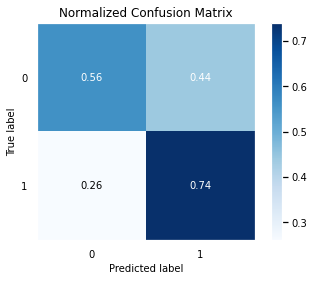

In [ ]:
# modelo final
rf = RandomForestClassifier(n_estimators=2000,
                            bootstrap= True,
                            max_depth=30,
                            min_samples_leaf=2,
                            min_samples_split=2,
                            random_state=42, max_features = 2)
rf.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = rf.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize= True)
plt.show()

#Conclusão
O objetivo principal deste artigo foi construir um algoritmo de Machine Learning que seriam capazes de identificar potenciais inadimplentes e, portanto, reduzir o prejuízo do emprestador. O melhor modelo possível seria aquele que pudesse minimizar os falsos negativos, identificando todos os inadimplentes entre a base de clientes, ao mesmo tempo em que minimizasse os falsos positivos, evitando que os clientes fossem erroneamente classificados como inadimplentes.

Atender a esses requisitos pode ser bastante complicado, pois há uma compensação entre precisão e recall, o que significa que aumentar o valor de uma dessas métricas geralmente diminui o valor da outra. Considerando a importância de minimizar as perdas da empresa, decidimos dar mais ênfase à redução de falsos positivos, buscando os melhores hiperparâmetros que pudessem aumentar a taxa de recall.

Pela matriz de confusão, obtemos um recall de 74%, isso indica que nosso modelo previu corretamente 74% dos clientes inadimplentes. Porém estamos lidando uma uma taxa consideravelmente alta de falsos positivos, cerca de 44%, isso indica que 44% dos clientes que foram taxados como inadimplentes, na verdade não eram. Isso acarreta numa quantidade alta de clientes que iriam pagar de volta a o emprestador com juros que não vão receber o empréstimo e acarreta de certa forma numa perda de lucro.

